# Robot Manipulation Object Classification - Feature Engineering 

The Data consists of an 'Action' vector:

Action modality - 34D vector which includes joint states for the two arms, gripper joints, pan and tilt joints, torso joint, and front and back wheels. The values represent velocity commands that are sent to robot's joints.

Data info does not specify which joints correspond with each of the dimensions.

Goal – Turn a time series data into an aggregated one row per episode data frame. To achieve that we first needed to understand which dimensions are usable.


### Import Libraries

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datasets import load_dataset

### Action Vector - PCA

As a first measure we performed PCA in order to achieve dimension reduction and explore the feature space. 

The main take aways from it are:
-   First 5 PCs capture ~70% variance
-   Found strong correlation among dimensions 15–20 & 28–33
-   Dims 1-4 are static and can be dropped


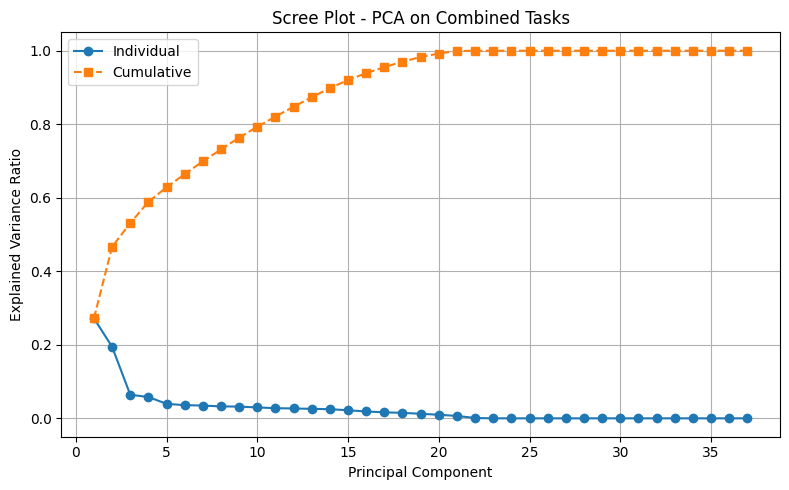

NameError: name 'task_labels' is not defined

In [10]:
# Appload Raw Data
df_full = pd.read_csv("C:/Users/danar/OneDrive/Desktop/Studies/MSc/Semester B/Statistical Lerning/project/RawData_PickPlace.csv")
#df_full = np.array(df_full)
# ------------------------------
# Step 2: Scale the data
# ------------------------------
scaler = StandardScaler()
scaled_actions = scaler.fit_transform(df_full.drop("task", axis=1))

# ------------------------------
# Step 3: PCA (all components)
# ------------------------------
pca = PCA()
pca_result = pca.fit_transform(scaled_actions)

# ------------------------------
# Step 4: Scree Plot
# ------------------------------
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', label="Individual")
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='s', linestyle='--', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot - PCA on Combined Tasks")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# Step 5: Create a DataFrame from PCA results
# ------------------------------
num_components = pca_result.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_components)]

df_pca = pd.DataFrame(pca_result, columns=pc_columns)
df_pca["task"] = task_labels  # add original task label for later grouping/filtering

# ✅ Preview
print(df_pca.head())

In [11]:
for i, component in enumerate(pca.components_[:5]):  # top 5 PCs
    print(f"\nTop 10 contributing dimensions to Principal Component {i+1}:")
    # Get indices of features with highest absolute weights
    top_dims = np.argsort(np.abs(component))[::-1][:-1]
    for dim in top_dims:
        weight = component[dim]
        print(f"  Dimension {dim}: weight = {weight:.4f}")


Top 10 contributing dimensions to Principal Component 1:
  Dimension 32: weight = 0.3181
  Dimension 33: weight = -0.3181
  Dimension 28: weight = 0.3181
  Dimension 30: weight = -0.3181
  Dimension 31: weight = -0.3181
  Dimension 29: weight = 0.3181
  Dimension 23: weight = -0.2606
  Dimension 22: weight = -0.2318
  Dimension 24: weight = 0.2152
  Dimension 26: weight = 0.2108
  Dimension 6: weight = -0.1794
  Dimension 21: weight = 0.1604
  Dimension 17: weight = -0.1339
  Dimension 15: weight = -0.1339
  Dimension 20: weight = -0.1339
  Dimension 18: weight = -0.1339
  Dimension 16: weight = 0.1339
  Dimension 19: weight = 0.1339
  Dimension 27: weight = 0.0711
  Dimension 11: weight = 0.0545
  Dimension 9: weight = -0.0519
  Dimension 7: weight = -0.0383
  Dimension 13: weight = 0.0367
  Dimension 36: weight = 0.0210
  Dimension 5: weight = 0.0186
  Dimension 25: weight = -0.0141
  Dimension 34: weight = 0.0130
  Dimension 14: weight = 0.0119
  Dimension 8: weight = 0.0062
  Dime

### Visualizations

Next we plotted the remaining dimension as a time series with all episodes overlayed and concluded the following:
-   Dimensions 21-33 are completely static for 'pick' and 'place bench' tasks, and contain minor noise in 'place cabinet task'. We therefore excluded them from the analysis
-   Dimension 15-20 exhibit the same data (with direction differences) – corresponds with synchronized weights in PCA. Only dimension 15 was included
-   Dimensions 15-20 are the only ones that suggest a separative behavior between 'pick' and 'place' tasks – Suspected as gripper related

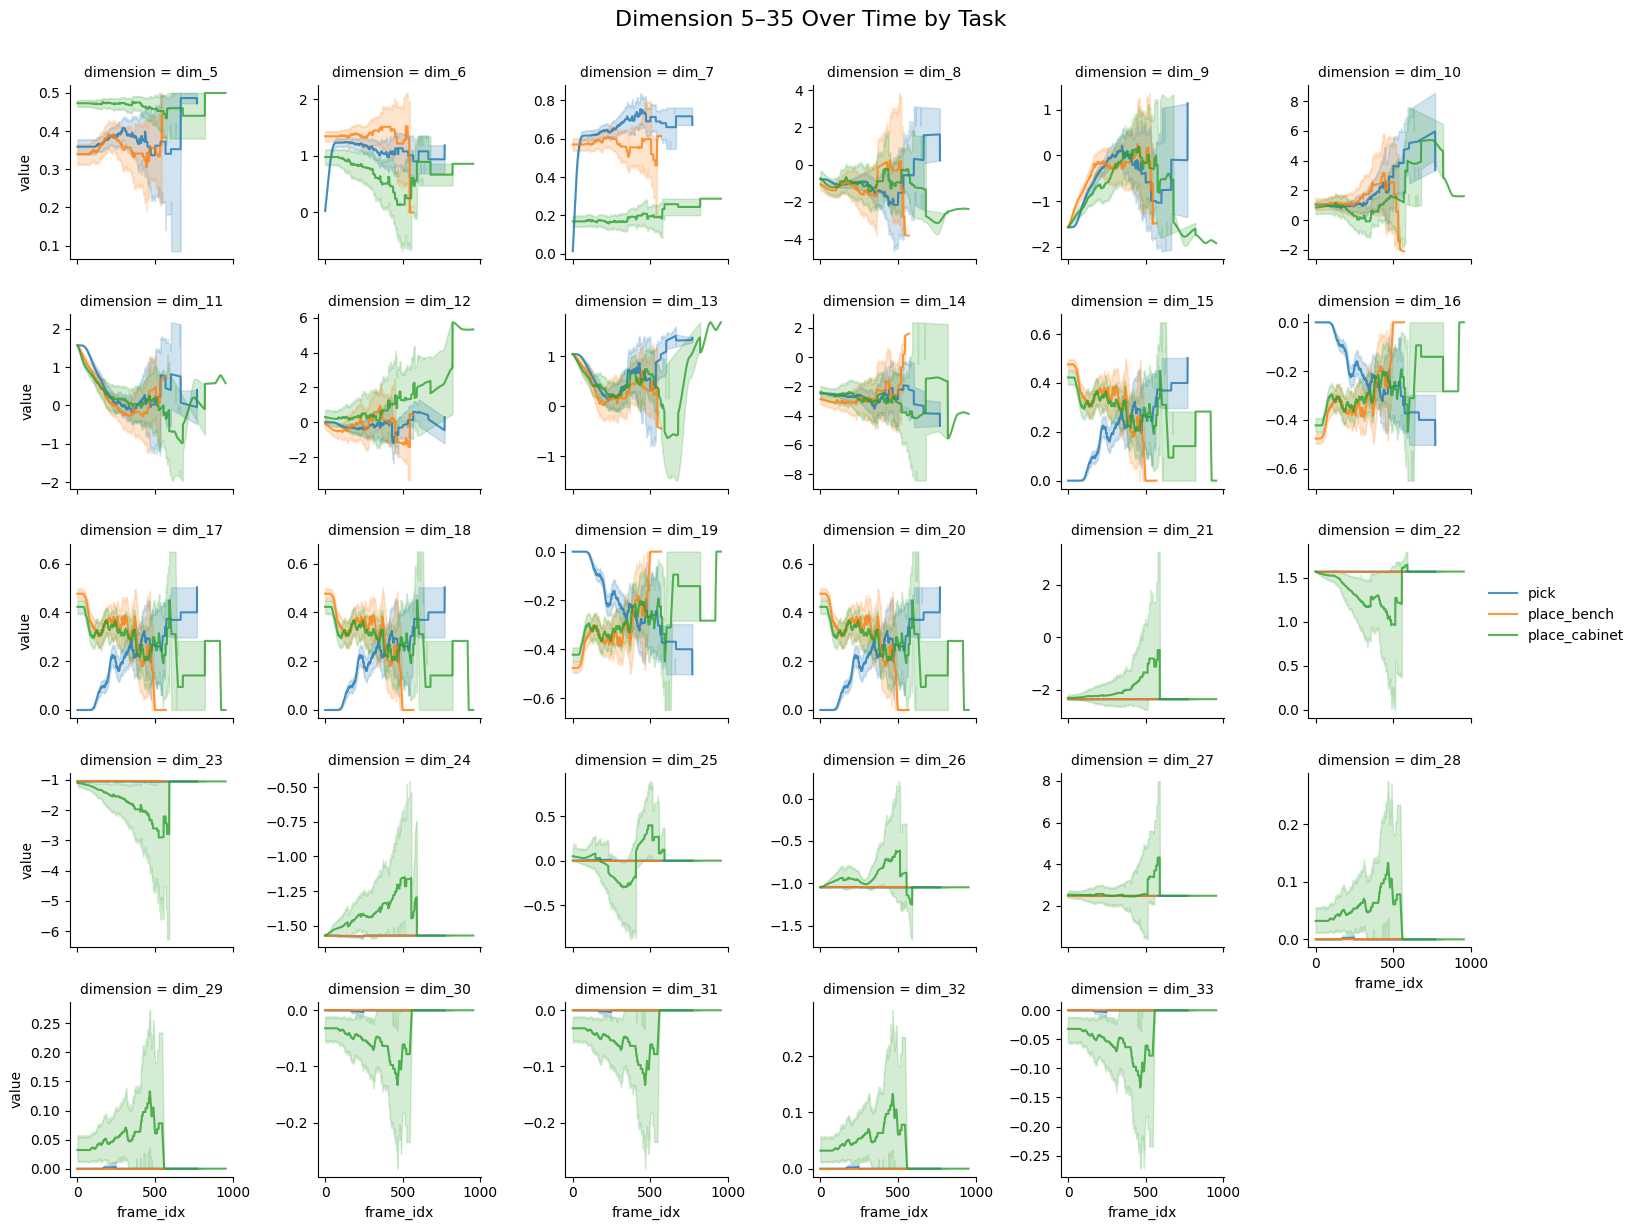

In [ ]:
dims = [f"dim_{i}" for i in range(5, 34)]
melted = df_full.melt(
    id_vars=["frame_idx", "task"],
    value_vars=dims,
    var_name="dimension",
    value_name="value"
)

# Create a grid: 6 rows × 6 columns (to fit 31 dimensions)
g = sns.FacetGrid(
    melted,
    col="dimension",
    col_wrap=6,
    height=2.5,
    sharey=False
)

# Draw one lineplot per facet
g.map_dataframe(
    sns.lineplot,
    x="frame_idx",
    y="value",
    hue="task",
    alpha=0.8
)

# Add legend
g.add_legend()

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Dimension 5–33 Over Time by Task", fontsize=16)
plt.show()

We aggregated dimensions 5-15 into one raw per episode using the mean statist.

'Pick' and 'Place bench' tasks are very similar in robot's movement, since they both manipulate the object on the bench (which is low), on the other hand, the movement in 'place cabinet' is different - the cabinet is significantly higher than the bench and the task distinguishes from the other two.
The only physical attribute that ties the two 'place' tasks together and separates them from the 'pick' task, is the motion of the gripper - when placing the gripper opens and when picking up the gripper closes.

We determine that with high probability dimension 15 represents the velocity commands that are signaled to the active gripper, we anticipate that this feature will play aa vital role in the models we will train. The histogram bellow supports that notion. 

<function matplotlib.pyplot.show(close=None, block=None)>

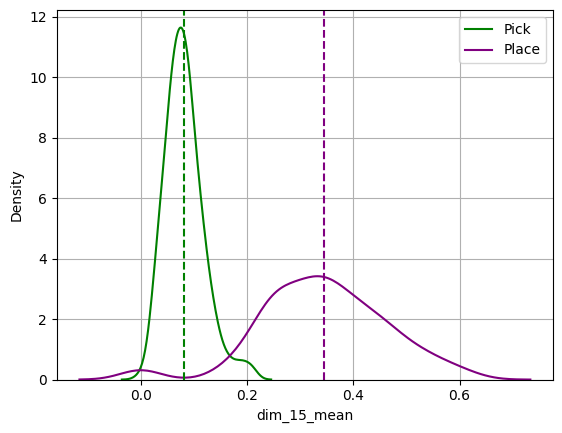

In [19]:
episode_features = []

# Selected dimensions
selected_dims = [5,6,7,8,9,10,11,12,13,14,15]

# Threshold for motion detection
motion_threshold = 1e-4

#Group by episode
for ep_id, group in df_full.groupby("episode_id_global"):
    group = group.sort_values("frame_idx")
    row = {
        "episode_id": ep_id,
        "task": group["task"].iloc[0],
    }

    # Initialize motion flags
    motion_flags = pd.Series([False] * len(group), index=group.index)

    for dim in selected_dims:
        dim_col = f"dim_{dim}"
        dim_values = group[dim_col]

        row[f"{dim_col}_mean"] = dim_values.mean()

        if dim == 15:
            # Calculate motion features for dimension 15 only
            motion_flags = dim_values.abs() > motion_threshold
            gripper_motion_time = motion_flags.sum()
            episode_length = len(group)

            row["gripper_motion_time"] = gripper_motion_time
            row["episode_length"] = episode_length

    episode_features.append(row)
#Create Data frame
df_episode = pd.DataFrame(episode_features)
#Create binary labels for 'pick' and 'place'
df_episode["task_label"] = df_episode["task"].apply(lambda x: 0 if x == "pick" else 1)

pick = df_episode[df_episode["task_label"]==0]["dim_15_mean"]
place = df_episode[df_episode["task_label"]==1]["dim_15_mean"]

sns.kdeplot(pick, label = "Pick", color = "green", fill=False)
sns.kdeplot(place, label = "Place", color = "purple", fill=False)
plt.axvline(pick.mean(), linestyle='--', color = 'green')
plt.axvline(place.mean(), linestyle='--', color = 'purple')
plt.legend()
plt.grid()
plt.show

### Additional Features
We add to the analysis the following features:
-   Episode length - total episode time
-   Gripper motion time - the total time dim_15 > 0 

The histograms are presented bellow

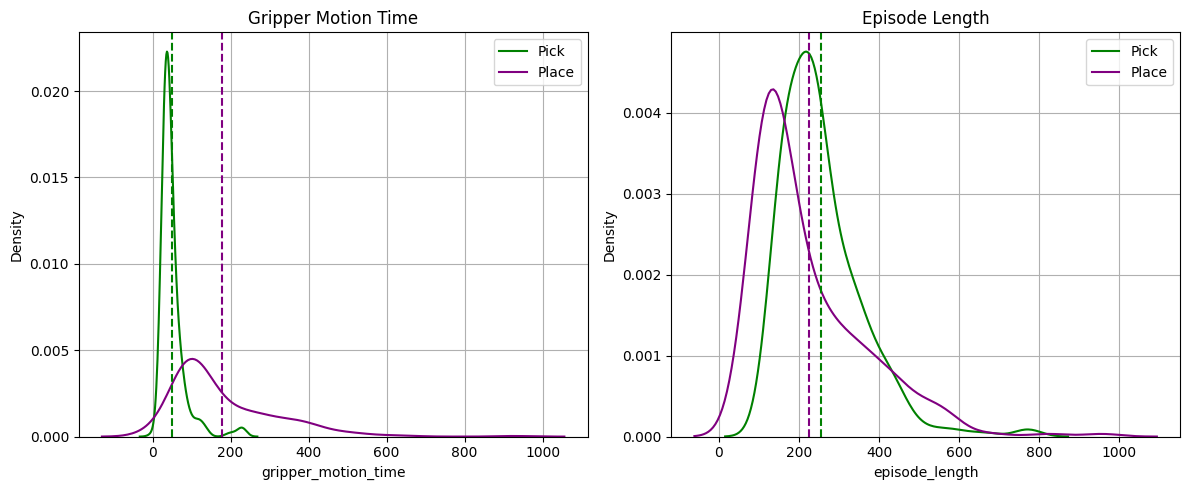

In [ ]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gripper Motion Time
pick = df_episode[df_episode["task_label"]==0]["gripper_motion_time"]
place = df_episode[df_episode["task_label"]==1]["gripper_motion_time"]

sns.kdeplot(pick, label="Pick", color="green", fill=False, ax=axes[0])
sns.kdeplot(place, label="Place", color="purple", fill=False, ax=axes[0])
axes[0].axvline(pick.mean(), linestyle='--', color='green')
axes[0].axvline(place.mean(), linestyle='--', color='purple')
axes[0].set_title("Gripper Motion Time")
axes[0].legend()
axes[0].grid()

# Episode Length
pick = df_episode[df_episode["task_label"]==0]["episode_length"]
place = df_episode[df_episode["task_label"]==1]["episode_length"]

sns.kdeplot(pick, label="Pick", color="green", fill=False, ax=axes[1])
sns.kdeplot(place, label="Place", color="purple", fill=False, ax=axes[1])
axes[1].axvline(pick.mean(), linestyle='--', color='green')
axes[1].axvline(place.mean(), linestyle='--', color='purple')
axes[1].set_title("Episode Length")
axes[1].legend()
axes[1].grid()

# Overall layout
plt.tight_layout()
plt.show()

### Feature Summary

The final features that will be used in the classification analysis are:

-   Mean statistic of dimensions 5-15
-   Episode length
-   Gripper motion time
